<a href="https://colab.research.google.com/github/sutummala/periCellNet/blob/main/PeriCellNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CPU model and speed
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [ ]:
# GPU Specs
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d27004f3-9300-7aa6-5324-14cd977cc459)


In [ ]:
# GPU Type
!nvidia-smi

Sat Nov 13 13:35:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.7 MB/s 


In [ ]:
import os
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
#import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold, cross_val_score
import sklearn
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
# Loading the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Normalizing the input to have values between zero and one to make them suitable for further analysis
def normalize(input):
  norm_input = []
  print(f'shape of input is {np.shape(input[0])}')
  for i in range(np.shape(input)[0]):
    norm_in = (input[i]-np.min(input[i]))/(np.max(input[i])-np.min(input[i]))
    norm_input.append(norm_in)
  return np.array(norm_input)

In [ ]:
# Data paths for loading individual cells 

basophil = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/basophil.npy')
print(f'basophil tensor shape is {basophil.shape}')
basophil_labels = np.zeros(len(basophil))

eosinophil = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/eosinophil.npy')
print(f'eosinophil tensor shape is {eosinophil.shape}')
eosinophil_labels = np.ones(len(eosinophil))

ig = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/ig.npy')
print(f'immature grannulocytes tensor shape is {ig.shape}')
ig_labels = 2 * np.ones(len(ig))

erythroblast = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/erythroblast.npy')
print(f'erythroblast tensor shape is {erythroblast.shape}')
erythroblast_labels = 3 * np.ones(len(erythroblast))

lymphocyte = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/lymphocyte.npy')
print(f'lymphocyte tensor shape is {lymphocyte.shape}')
lymphocyte_labels = 4 * np.ones(len(lymphocyte))

monocyte = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/monocyte.npy')
print(f'monocyte tensor shape is {monocyte.shape}')
monocyte_labels = 5 * np.ones(len(monocyte))

platelet = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/platelet.npy')
print(f'platelet tensor shape is {platelet.shape}')
platelet_labels = 6 * np.ones(len(platelet))

neutrophil = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/neutrophil.npy')
print(f'neutrophil tensor shape is {neutrophil.shape}')
neutrophil_labels =  7 * np.ones(len(neutrophil))


In [ ]:
X = np.concatenate((basophil, eosinophil, ig, erythroblast, lymphocyte, monocyte, platelet, neutrophil))
y = np.concatenate((basophil_labels, eosinophil_labels, ig_labels, erythroblast_labels, lymphocyte_labels, monocyte_labels, platelet_labels, neutrophil_labels))
print(X.shape)
print(y.shape)
np.save('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/all_data', X)
np.save('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/all_labels', y)

In [ ]:
X = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/all_data.npy')
y = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/all_labels.npy')
print(X.shape)
print(y.shape)
print(np.unique(y))

(17092, 358, 358, 3)
(17092,)
[0. 1. 2. 3. 4. 5. 6. 7.]


In [ ]:
#X = tf.image.resize(X, [360, 360])
#print(X.shape)

In [ ]:
folds = StratifiedKFold(n_splits = 7, shuffle = True)

#X_train = np.expand_dims(X_train, axis = -1) * 255 # expanding dimensions

for train_index, test_index in folds.split(X, y):
    input_cv, input_test, targets_cv, targets_test = X[train_index], X[test_index], y[train_index], y[test_index]

print(f'shape of input for CV is {input_cv.shape}')
print(f'shape of input for testing is {input_test.shape}')

#for train_ind, test_ind in folds.split(input_cv, targets_cv):
    #x_train, x_test, y_train, y_test = input_cv[train_ind], input_cv[test_ind], targets_cv[train_ind], targets_cv[test_ind]

#print(f'shape of input for training is {x_train.shape}')
#print(f'shape of input for validation is {x_test.shape}')

shape of input for CV is (14651, 358, 358, 3)
shape of input for testing is (2441, 358, 358, 3)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001

batch_size = 32
num_epochs = 10

In [ ]:
IMG_SIZE = 300

In [ ]:
size = (IMG_SIZE, IMG_SIZE)
input_cv = input_cv[:, 30:330, 30:330, :]
input_test = input_test[:, 30:330, 30:330, :]

input_cv.shape

(14651, 300, 300, 3)

In [ ]:
inp = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_tensor=inp,
                                          input_shape=(IMG_SIZE, IMG_SIZE, 3))

last_conv_layer = base_model.get_layer('top_activation')

x =  tf.keras.layers.GlobalAveragePooling2D()(last_conv_layer.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation = 'relu', name = 'dense_layer')(x)
x = tf.keras.layers.Dense(8, activation = 'softmax', name = 'prediction')(x)

model = tf.keras.models.Model(inputs = inp, outputs = x)
model.summary()

In [ ]:
index = int(0.9 * len(model.layers))
for layer in model.layers[:index]:
  layer.trainable = False

In [ ]:
#model = CNN_Network(img_shape)
model.summary()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate), loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
    
fine_tune_epochs = 40
history_fine = model.fit(input_cv, targets_cv, batch_size = 32,
                              epochs = fine_tune_epochs,
                              shuffle = True,
                              validation_split = None)

Epoch 1/40
458/458 [==============================] - 89s 139ms/step - loss: 0.3762 - accuracy: 0.9030
Epoch 2/40
458/458 [==============================] - 63s 137ms/step - loss: 0.1847 - accuracy: 0.9497
Epoch 3/40
458/458 [==============================] - 63s 137ms/step - loss: 0.1859 - accuracy: 0.9599
Epoch 4/40
458/458 [==============================] - 63s 137ms/step - loss: 0.1608 - accuracy: 0.9662
Epoch 5/40
458/458 [==============================] - 63s 137ms/step - loss: 0.1039 - accuracy: 0.9718
Epoch 6/40
458/458 [==============================] - 63s 137ms/step - loss: 0.1016 - accuracy: 0.9750
Epoch 7/40
458/458 [==============================] - 63s 137ms/step - loss: 0.0909 - accuracy: 0.9771
Epoch 8/40
458/458 [==============================] - 63s 137ms/step - loss: 0.1220 - accuracy: 0.9799
Epoch 9/40
458/458 [==============================] - 63s 137ms/step - loss: 0.0896 - accuracy: 0.9821
Epoch 10/40
458/458 [==============================] - 63s 137ms/step - l

In [ ]:
score = model.evaluate(input_test, targets_test)

77/77 [==============================] - 11s 120ms/step - loss: 0.1196 - accuracy: 0.9848


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
model.layers[-1].activation = None

last_conv_layer_name = 'top_conv'

index = 1200

img_array = np.expand_dims(input_test[index], axis = 0)
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

#last_layer = model.get_layer(last_conv_layer_name)
#s_model = tf.keras.models.Model([model.inputs], [last_layer.output, model.output])

(10, 10)


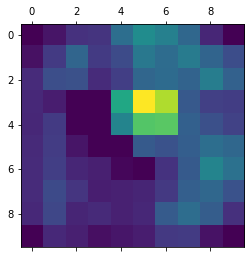

In [ ]:
# Display heatmap
print(heatmap.shape)
plt.matshow(heatmap)
plt.show()

In [ ]:
from IPython.display import Image, display
import matplotlib.cm as cm
from skimage.transform import resize

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    jet_heatmap_path = 'heatmap.jpg'

    # Save the superimposed image
    superimposed_img.save(cam_path)

    jet_heatmap1 = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap1.save(jet_heatmap_path)

    # Display Grad CAM
    display(Image(cam_path))
    display(Image(jet_heatmap_path))

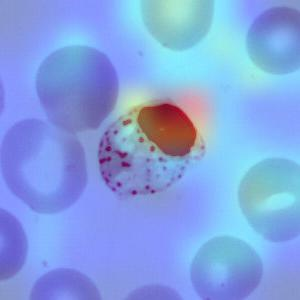

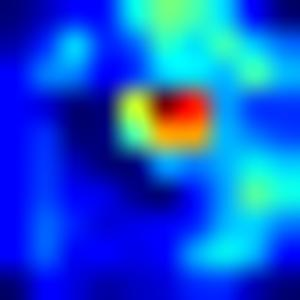

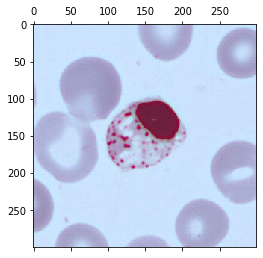

In [ ]:
save_and_display_gradcam(np.squeeze(img_array), heatmap)
plt.matshow(np.squeeze(img_array))
plt.show()